## Responses to review comments (February 2025)

In [1]:
import json
import fluid_flow_model as fl
import simulation_model as sm
import deterministic_optimisation as do
import matplotlib.pyplot as plt
import math
import numpy as np
import time

In [2]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [10.0]*5 + [6.0]*5,
        'budget' : 200000000.0, # in dollars
        'costs_accomm' : {'housing' : 30000.0, 'shelter' : 10000.0}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'T_a' : 5, # in days: modelling and building
                    'T_b' : 5, # in days: extra modelling following all building
                    'model' : do.FluidModel}


#### Exploring different weights for penalty on shelter

In our formulation $\Phi_2$, our objective function is a quadratic combination of the unsheltered and sheltered queues over time. We weighted the squared sheltered queue at 0.3 (with no weight on the squared unsheltered queue) to give a meaningful penalty to building shelter but without undermining the improvement that a sheltered population represents compared to an unsheltered population. We use policy-based shape constraints to ensure that the housing stock increases (at a non-decreasing rate) during the 5 year planning horizon and the shelter stock increases and then decreases during the same horizon. Given the data we used (see paper for details), and the weight $w=0.3$ on the squared sheltered queue, we obtain the following optimal solution. 

------- Optimal solution -------
Housing capacity at end of each year: [5094.07, 6188.13, 7282.2, 8376.26, 9470.33]
Shelter capacity at the end of each year: [8148.31, 8148.31, 9040.33, 8371.21, 5089.01]
Optimal objective val: 42678726.81


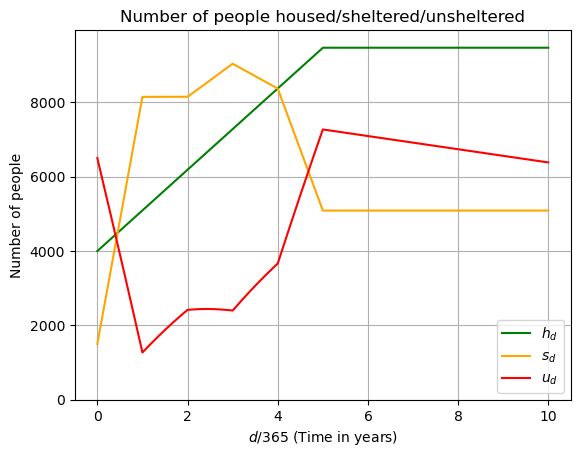

solved in 0.8276979755610228 seconds.


In [3]:
# Set up problem and solve
problem2 = do.Phi2(data, modeling_options, 'phi2', c=0.3, shelter_mode = 3)
tic = time.perf_counter()
problem2.solve('ipopt')
toc = time.perf_counter()
print('solved in '+str(toc-tic) + ' seconds.')

It was noted in the review that our results are likely to change with a different choice of $w$, which is of course true. Below we explore these changes, by choosing a range of weights $w$ from $0.2$ to $0.8$. Note: a weight too low could encourage so much shelter to be built that our unsheltered queue would vanish which is unlikely in practice and violates our assumption of shelter and housing always being busy. 

In [4]:
# Set up problem and solve
problems = []
models = []
weights = [0.2,0.4,0.6,0.8] 
for w in weights:
    problems.append(do.Phi2(data, modeling_options, 'phi2', c=w, shelter_mode = 3))
    problems[-1].solve('ipopt', print = False)
    models.append(problems[-1].problem.selected_model(problems[-1].problem.data, 
                                                      {'housing' : problems[-1].h_opt, 'shelter' : problems[-1].s_opt}, 
                                                      problems[-1].problem.horizon_decision, 
                                                      problems[-1].problem.horizon_extra_model))
    models[-1].analyse(problems[-1].problem.horizon_model)

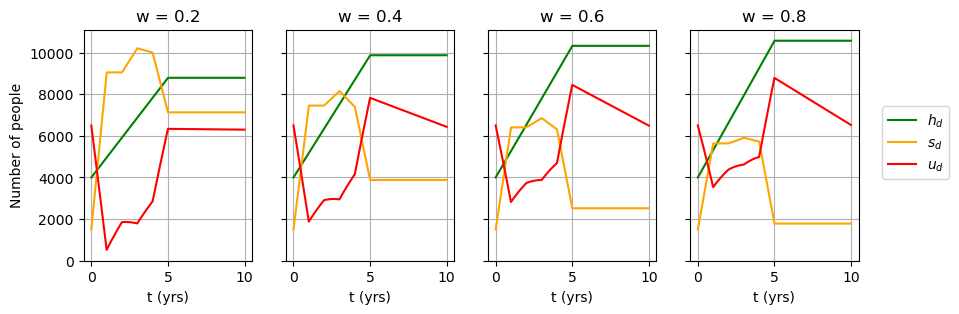

In [5]:
fig, axs = plt.subplots(1, 4,  figsize=(10, 3))
ymax = 0
for i in range(len(models)):
    ymax = max(ymax, max(models[i].model.h_t + models[i].model.sh_t + models[i].model.unsh_t))
    x = [j/365 for j in range(problems[i].problem.horizon_model*365)]
    axs[i].plot(x, models[i].model.h_t, color = 'green')
    axs[i].plot(x, models[i].model.sh_t, color = 'orange')
    axs[i].plot(x, models[i].model.unsh_t, color = 'red')
    axs[i].set(title = 'w = ' + str(weights[i]))
axs[i].legend(["$h_d$", "$s_d$", "$u_d$"], bbox_to_anchor=(1.1, 0.7))

# formatting
for ax in axs.flat:
    ax.set(xlabel='t (yrs)', ylabel='Number of people')
    ax.grid()
    ax.set_ylim(0, ymax*1.05)
    ax.label_outer()
plt.show()

We see with these results that by increasing $w$, it is optimal to not ramp up shelter so much, and to decomission so that the final shelter capacity is closer to the initial shelter capacity. We also note that by increasing $w$, the optimal shelter capacity is less variable between the initial ramp up (year $1$) and the final decomission (year $5$). The result of less shelter is two-fold. Firstly, our unsheltered queue does not enjoy such a large decrease as shelter increases less. Secondly, we can afford to build more houses so by the end of the planning horizon, our overall service rate is higher and the unsheltered queue can reduce more quickly between years $5$ and $10$. The total unsheltered queue is roughly the same by year $10$ for all weights, but we would expect that beyond year $10$, greater housing levels would lead to greater decreases in the unsheltered queue. 

#### Discrete-event simulation of optimal solution

We have developed a discrete-event simulation (DES) model of the flow of people through the homeless care system in Alameda County. We have scaled down customer, shelter and housing numbers by a factor of $100$ to ease the computational burden. This model captures stochasticity associated with the arrival and service processes. We model inter-arrival times as exponential and service times in housing as triangular. We have matched the mean of these distributions with the fixed arrival and service rates in the fluid model (taking scaling into account). DES models are capable of handling many real-world complexities, such as tandem queueing and re-entries to the system, which we do not model here. However, one key difference in the DES model is the fact that when a shelter is to be decomissioned, the resident stays in shelter until a house becomes available for them, before that shelter is removed from the system. Below we illustrate the outputs (including $10^{\text{th}}-90^{\text{th}}$ percentile range) for the optimal solution to $\Phi_2$ after $100$ simulation replications. We model this system for a total of $15$ years

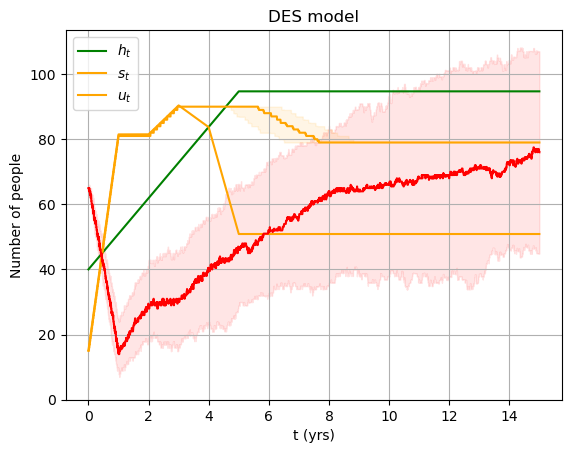

In [6]:
simulation_data = {"T_a":15-(1/365),
 "T_b":0,
 "initial_capacity": {"housing": 40, "shelter": 15},
 "initial_demand": 120,
 "service_mean": {"housing": (0+6+8)/3, "shelter": 0.0},
 "service_dist_triangle": {"low":0,"mid":6,"high":8},
 "arrival_rates" : [36.5]*5 + [(6/10)*36.5]*10,
 "solution": {'housing':[h/100 for h in problem2.h_opt[1:6]]+[problem2.h_opt[5]/100]*10,'shelter':[s/100 for s in problem2.s_opt[1:6]]+[problem2.s_opt[5]/100]*10},
 "max_in_system":500,
 "delta_t":1,
 "simulation_reps":100,
 "time_btwn_building":1/365,
 "simulation_build_time":0,
 "reentry_rate":0.0,
 "seed":12345}

with open('data_simulation.json') as json_file:
    data = json.load(json_file)

solution = data['solution']

s = sm.SimulationModel(simulation_data, simulation_data['solution'])
s.analyse()
s.plot()